# We're going to start playing with the Jyro robot simulator today!
### First we'll just walk through some of the features of this package, and write a simple robot brain by hand.

In [1]:
!pip install jyro

  Using cached jyro-0.3.2-py3-none-any.whl (142 kB)
  Using cached calysto-1.0.6-py3-none-any.whl (82 kB)
     |████████████████████████████████| 45 kB 4.0 MB/s eta 0:00:011
     |████████████████████████████████| 217 kB 27.4 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 19.6 MB/s eta 0:00:01


  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89649 sha256=8047547ad3c29d948780c5156d16b0e1ccac4666b3dadf082f5f34ea915c737b
  Stored in directory: /Users/zamanlh/Library/Caches/pip/wheels/f3/97/83/8022b9237866102e18d1b7ac0a269769e6fccba0f63dceb9b7
Successfully built cairocffi


In [1]:
from jyro.simulator import *
import random
import numpy as np

# We'll create a box for the robot to live in
# and a light source
def make_world(sim):
    sim.addBox(0, 0, 8, 8, fill="backgroundgreen", wallcolor="gray") #bounding box
    sim.addLight(7, 7, 1) #paramters are x, y, brightness

#We'll give our robot the 16 sonar distance sensors, some light sensors
#and a camera for funsies.
class MyPioneer(Pioneer):
    def __init__(self, name, x, y, angle):
        Pioneer.__init__(self, name, x, y, angle)
        self.addDevice(Pioneer16Sonars())
        #parameter defines max range in meters
        self.addDevice(PioneerFrontLightSensors(3))
        self.addDevice(Camera(60, 40))


## We can see a visual representation of the robot thanks to the developers of this package!

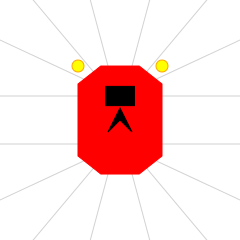

In [2]:
robot = MyPioneer("Johnny", 1, 1, 0)
robot

## And we can get a little visual simulator running in the Notebook
Spend a bit of time playing with the sliders and seeing how the camera output changes

In [3]:
sim = VSimulator(robot, make_world)

## In Jyro, robots get brains which are executed in each timestep. 
## We can give a robot a very silly brain, that just randomly moves forward/backward and left/right in every timestep

In [4]:
def my_robot_brain(a_robot):
    a_robot.move(random.uniform(-1,1), random.uniform(-1, 1))
    
robot.brain = my_robot_brain

#### After running the cell above, go back to your visual simulator and hit the play button to watch the robot run with it's silly brain.

# We can tell the robot to move each timestep in different directions, for example:
```python
robot.move(-1, 0) # straight back
robot.move(1, 0) # straight forward
robot.move(0.3, 0.3) # slow forward, left arc
robot.move(0, -1.0) # turning right in place
```

### Although we wont use this in controllers, we can put the robot in a specific place with the `setPose` function, which takes `x, y`, and  `rotation` arguments. To see these changes in our visual simulator, we'll also need to call `update_gui()` on our simulator instance.

### We can also query the robot's sensors to get their view of the world. 
For example, here we're asking the robot to tell us the value of it's forward facing light sensors (those little yellow circles on the front of the robot). 

In [5]:
robot.setPose(1, 1, 0)
sim.update_gui()

robot["light"].getData()

[0.0, 0.0]

### We can move the robot within range of the light (remember that was a parameter to our light sensors when we built the robot) and again query the light sensors. 

In [6]:
robot.setPose(7, 6, 0)
sim.update_gui()

robot["light"].getData()

[0.7351625236321548, 0.7351625236321548]

## Our robot also has 16 distance sensors arrayed around its body. We can query their data the same way. Note that the sensors start indexing from the robot's left front sensor, and end back at the robot's left back sensor going clockwise. 
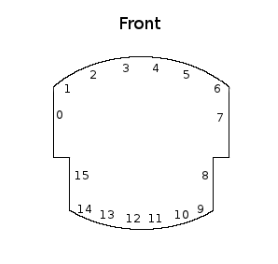

In [7]:
robot["sonar"].getData()

[6.825,
 4.330148657421216,
 2.3497330975811885,
 1.8376152159404975,
 1.8376152159404975,
 1.384594207890705,
 0.9378712271320886,
 0.8250000000000002,
 0.8250000000000002,
 0.9378712271320886,
 1.384594207890705,
 3.670518074997485,
 5.978719945416708,
 7.571362239027587,
 7.5581388470138124,
 6.825]

## Remember we also have a camera, though I don't suspect it'll do us much good. 

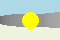

In [8]:
robot["camera"].getImage()

## We also have a few more bits of information we can get from our robot. We can always ask the robot for it's current position in the world. We can also ask if it's currently stalled, or stuck on a wall.

In [9]:
print(robot.getPose())
print(robot.stall)

(7.0, 6.0, 0.0)
0


# 1. Write a simple brain that wanders through the world that avoids hitting the wall. 
After you execute this cell, you can scroll back up and hit play to watch your robot run around the world. 

In [10]:
robot.reset()
sim.update_gui()

def better_brain(a_robot):
    #IMPLEMENT THIS FUNCTION
    sonar_sensor = a_robot["sonar"].getData()
    #Move the robot
    a_robot.move(1,1)
    
robot.brain = better_brain

# 2. Let's bring in some neural networks from our previous worksheets.
### Note that I've changed the activation function from before. The hyperbolic tangent function `tanh` squashes values between -1 and 1, which is convinently the range `robot.move()` expects!

In [11]:
class SimpleNeuralNet():
    #This is our squashing function
    #I changed this to the hyperbolic tangent function that
    #returns values in (-1, 1)
    def activation_function(self, x):
        return np.tanh(x)
    
    #this should look familiar, just a way to create a copy of 
    #the network without worying about pesky reference 
    def deepcopy(self):
        new_net = SimpleNeuralNet(self.num_inputs, self.num_outputs, self.layer_node_counts)
        new_net.layers = [np.copy(layer) for layer in self.layers]
        return new_net
    
    #this is where the neural network does its computation!
    def execute(self, input_vector):
        # First we need to make sure we're getting the right
        # number of inputs into our neural network.
        assert len(input_vector) == self.num_inputs ,\
        "wrong input vector size"

        # create a temporary variable to hold the values that should go
        # into the next layer of the network.
        # **at the start, this will just be our input**
        next_v = input_vector

        # iterate through layers, computing the activation
        # of the weighted inputs from the previous layer
        for layer in self.layers:
            # add a bias to each layer [1]
            next_v = np.append(next_v, 1)
            
            # pump the input vector through the matrix multiplication
            # and our activation function
            next_v = self.activation_function(np.dot(next_v, layer))
            
        return next_v
        
    def __init__(self, num_inputs, num_outputs, layer_node_counts=[]):
        self.num_inputs = num_inputs
        self.layer_node_counts = layer_node_counts
        self.num_outputs = num_outputs
        self.layers = []
        
        last_num_neurons = self.num_inputs
        for nc in layer_node_counts + [num_outputs]:
            # for now, we'll just use random weights in the range [-5,5]
            # +1 handles adding a bias node for each layer of nodes
            self.layers.append(np.random.uniform(-5, 5, size=(last_num_neurons+1, nc)))
            last_num_neurons = nc
    

In [12]:
my_brain = SimpleNeuralNet(num_inputs=18,
                           num_outputs=2,
                           layer_node_counts=[])

def neural_brain(a_robot):
    sonar_sensors = robot["sonar"].getData()
    light_sensors = robot["light"].getData()
    combined_input = sonar_sensors + light_sensors
    
    # We want to build a network that takes all these sensor values as input,
    # and returns forward/backward and a left/right value between -1 and 1.
    
    output = my_brain.execute(combined_input)
    a_robot.move(output[0], output[1])
    
#assign this neural network to the robot brain
robot.brain = neural_brain

## Now go back and hit play on your simulator!
(totally random networks are probably not going to be very interesting -- but you may be suprised!)

## Try adding more layers to the robot's brain and see if anything interesting happens.